<a href="https://colab.research.google.com/github/CrisztinaZudor/Humor-Detection/blob/main/HumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humor Detection in text using DeepLearning Techniques (DistilBERT)

Imports necessary libraries

In [24]:
import pandas as pd # Data manipulation and analysis
import torch # PyTorch framework for building and training the deep learning model
import numpy as np # Numerical operations and computations
from wordcloud import WordCloud, STOPWORDS # Creating word clouds for visualization
from textblob import TextBlob # Sentiment analysis on text data
import matplotlib.pyplot as plt # Plotting graphs and visualizations
from sklearn.model_selection import train_test_split # Splitting the dataset into training and validation sets
from sklearn.metrics import classification_report # Calculating evaluation metrics like precision, recall, F1-score, etc.
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification # Tokenizer and pre-trained model for natural language processing tasks
#from transformers.optimization import AdamW # Optimizer specifically designed for transformers
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset # DataLoader for batching and iterating over datasets

Sets up the device for computation, utilizing GPU if available, otherwise defaults to CPU

In [25]:
# Check if a GPU is available; if yes, use it for computation, otherwise default to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loads the dataset, samples 4,000 random entries, and extracts text and humor labels for processing

In [26]:
# Load the dataset from a CSV file into a Pandas DataFrame.
data = pd.read_csv('dataset.csv')

# Randomly sample 4,000 entries from the dataset for computational efficiency.
# The random_state ensures reproducibility of the random sampling.
data = data.sample(4000, random_state=42)

# Extract the 'text' column as a list of input texts.
texts = data['text'].tolist()

# Extract the 'humor' column as a list of labels (0 for Not Funny, 1 for Funny).
labels = data['humor'].tolist()

Displays a random sample from the dataset

In [27]:
# Display a random entry from the dataset to inspect its content.
print("Random sample from the dataset:")

# Adjust Pandas settings to ensure the full text content is displayed without truncation.
pd.set_option('display.max_colwidth', None)

# Print a randomly selected sample from the dataset.
print(data.sample(1))


Random sample from the dataset:
                                                                   text  humor
45465  The all-too-common mistakes people make with thanksgiving turkey  False


Generates and displays a word cloud visualizing the most common words in humorous texts

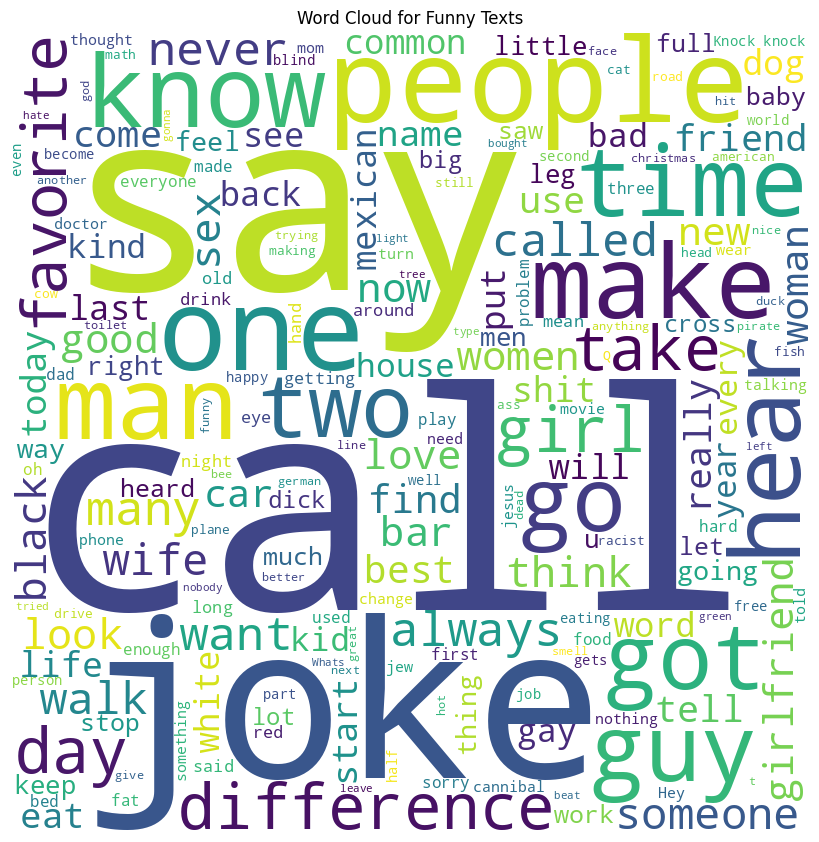

In [28]:
# Concatenate all text entries labeled as 'humorous' into a single string.
string = ""
for i in data[data.humor == 1].text.values:
    string = string + " " + i.strip()

# Create a WordCloud object with specified dimensions, background color, and stop words.
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      stopwords=set(STOPWORDS), min_font_size=10).generate(string)

# Plot the generated word cloud.
plt.figure(figsize=(8, 8), facecolor=None)  # Set the figure size and remove the background facecolor.
plt.imshow(wordcloud)  # Display the word cloud image.
plt.axis("off")  # Hide the axes for a cleaner visualization.
plt.tight_layout(pad=0)  # Remove padding around the figure.
plt.title("Word Cloud for Funny Texts")  # Add a title to the plot.
plt.show()

# Delete the string variable to free up memory.
del string


Generates and displays a word cloud visualizing the most common words in non-humorous texts

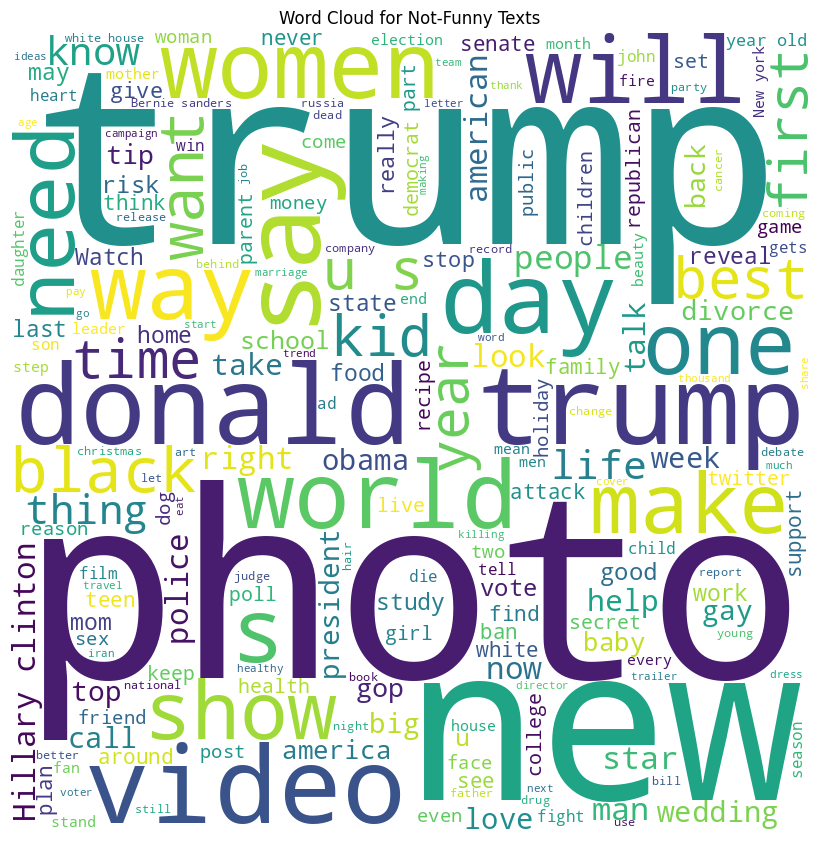

In [29]:
# Concatenate all text entries labeled as 'non-humorous' into a single string.
string = ""
for i in data[data.humor == 0].text.values:
    string = string + " " + i.strip()

# Create a WordCloud object with specified dimensions, background color, and stop words.
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      stopwords=set(STOPWORDS), min_font_size=10).generate(string)

# Plot the generated word cloud.
plt.figure(figsize=(8, 8), facecolor=None)  # Set the figure size and remove the background facecolor.
plt.imshow(wordcloud)  # Display the word cloud image.
plt.axis("off")  # Hide the axes for a cleaner visualization.
plt.tight_layout(pad=0)  # Remove padding around the figure.
plt.title("Word Cloud for Not-Funny Texts")  # Add a title to the plot.
plt.show()

# Delete the string variable to free up memory.
del string


Analyzes and visualizes the sentiment distribution (Negative, Neutral, Positive) for humorous and non-humorous texts

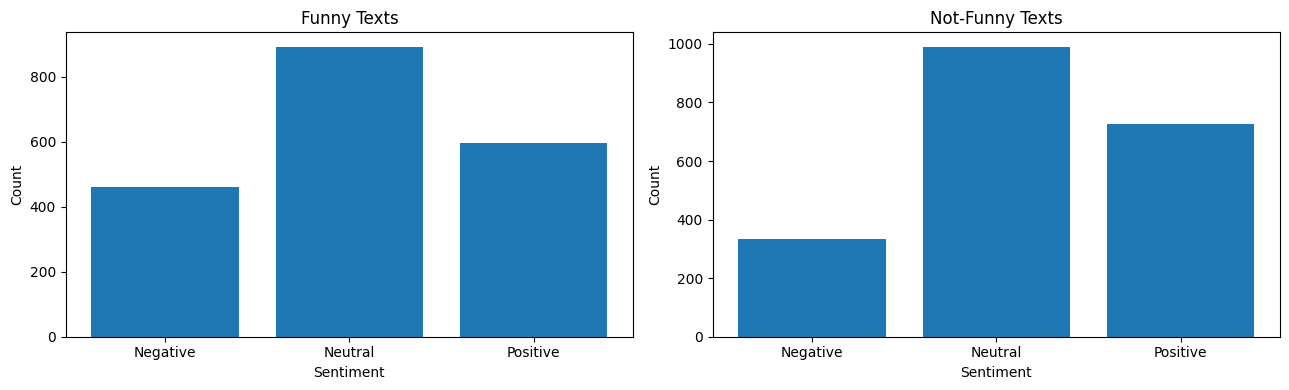

In [30]:
# Compute sentiment polarity for each text in the dataset.
sentiment = []
for text in data.text.values:
    polarity = TextBlob(text).sentiment.polarity  # Calculate sentiment polarity (-1 to 1).
    if polarity < 0:
        sentiment.append("Negative")  # Classify as negative sentiment.
    elif polarity == 0:
        sentiment.append("Neutral")  # Classify as neutral sentiment.
    else:
        sentiment.append("Positive")  # Classify as positive sentiment.

# Add the computed sentiments as a new column in the dataset.
data["sentiment"] = sentiment

# Clean up the temporary sentiment list to free memory.
del sentiment

# Create a figure to plot sentiment distributions.
plt.figure(figsize=(13, 4))

# Plot sentiment distribution for humorous texts.
plt.subplot(1, 2, 1)  # Create the first subplot.
un, count = np.unique(data[data.humor == 1].sentiment, return_counts=True)  # Count sentiment categories.
plt.bar(un, count)  # Create a bar chart.
plt.xlabel("Sentiment")  # Label the x-axis.
plt.ylabel("Count")  # Label the y-axis.
plt.title("Funny Texts")  # Add a title to the chart.

# Plot sentiment distribution for non-humorous texts.
plt.subplot(1, 2, 2)  # Create the second subplot.
un, count = np.unique(data[data.humor == 0].sentiment, return_counts=True)  # Count sentiment categories.
plt.bar(un, count)  # Create a bar chart.
plt.xlabel("Sentiment")  # Label the x-axis.
plt.ylabel("Count")  # Label the y-axis.
plt.title("Not-Funny Texts")  # Add a title to the chart.

# Adjust layout for better visualization.
plt.tight_layout()

# Display the plots.
plt.show()


Removes the 'sentiment' column from the dataset to clean up after sentiment analysis

In [31]:
data.drop(columns=['sentiment'], inplace=True)

Defines a custom PyTorch dataset class to preprocess text data into tokenized inputs and labels for model training

In [32]:
# Define a custom PyTorch Dataset class to handle text data for humor classification
class FunnyNotFunnyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        # Initialize the dataset with texts, labels, a tokenizer, and the maximum sequence length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Retrieve a single data sample, tokenize the text, and prepare inputs for the model
        text = self.texts[idx]  # Get the text at the specified index
        label = self.labels[idx]  # Get the label at the specified index
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,  # Add special tokens ([CLS], [SEP]) to the input
            max_length=self.max_len,  # Truncate or pad the text to the specified maximum length
            truncation=True,  # Enable truncation for texts longer than max_len
            padding="max_length",  # Pad shorter texts to max_len
            return_tensors="pt"  # Return PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Tokenized input IDs
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Attention mask for the input
            'label': torch.tensor(label, dtype=torch.long)  # Convert the label to a PyTorch tensor
        }


Divides the texts and labels into training and validation sets, using 30% of the data for validation

In [33]:
# Split the dataset into training and validation sets
# 30% of the data is allocated for validation, ensuring reproducibility with a fixed random state
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)


Initializes the DistilBERT tokenizer and model for binary classification, with dropout regularization set to 0.3 and the model configured to run on the selected device (GPU or CPU)

In [34]:
# Initialize the DistilBERT tokenizer and model for text classification
model_name = "distilbert-base-uncased"  # Specify the pre-trained model to use
tokenizer = DistilBertTokenizer.from_pretrained(model_name)  # Load the tokenizer for the model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Load the model for binary classification
model.config.hidden_dropout_prob = 0.3  # Set the dropout probability to reduce overfitting
model.to(device)  # Move the model to the selected device (GPU or CPU)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mod

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Creates PyTorch datasets and DataLoaders for training and validation, with tokenized inputs, a maximum sequence length of 32, and a batch size of 128

In [35]:
# Set the maximum sequence length and batch size for data processing
max_len = 32  # Set the maximum length for tokenized inputs
batch_size = 128  # Set the batch size for training and validation

# Create training and validation datasets using the custom dataset class
train_dataset = FunnyNotFunnyDataset(train_texts, train_labels, tokenizer, max_len)  # Training dataset
val_dataset = FunnyNotFunnyDataset(val_texts, val_labels, tokenizer, max_len)  # Validation dataset

# Create DataLoaders for batching and iterating over the datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader for training with shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # DataLoader for validation without shuffling


Defines the AdamW optimizer with a learning rate of 5e-6 and weight decay of 0.01 to regularize the model and optimize its parameters

In [36]:
# Define Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=0.01)

Implements the training loop to fine-tune the DistilBERT model, tracking metrics such as loss and accuracy for training and validation. Includes early stopping to halt training if validation loss does not improve within the defined patience interval

In [37]:
# Training loop to fine-tune the DistilBERT model and evaluate its performance
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}  # Dictionary to store training and validation metrics
epochs = 4  # Set the maximum number of epochs for training
best_val_loss = float('inf')  # Initialize the best validation loss to a very high value
patience = 1  # Set the number of epochs to wait for validation loss improvement before early stopping
counter = 0  # Initialize the counter for early stopping

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0  # Accumulate total training loss
    correct = 0  # Count correct predictions during training

    # Training loop
    for batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        input_ids = batch['input_ids'].to(device)  # Move input IDs to the selected device
        attention_mask = batch['attention_mask'].to(device)  # Move attention masks to the selected device
        labels = batch['label'].to(device)  # Move labels to the selected device

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)  # Forward pass
        loss = outputs.loss  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate the batch loss
        correct += (outputs.logits.argmax(1) == labels).sum().item()  # Count correct predictions

    train_accuracy = correct / len(train_dataset)  # Calculate training accuracy
    train_loss = total_loss / len(train_loader)  # Calculate average training loss

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0  # Accumulate validation loss
    val_correct = 0  # Count correct predictions during validation
    with torch.no_grad():  # Disable gradient computation for validation
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)  # Move input IDs to the selected device
            attention_mask = batch['attention_mask'].to(device)  # Move attention masks to the selected device
            labels = batch['label'].to(device)  # Move labels to the selected device

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)  # Forward pass
            val_loss += outputs.loss.item()  # Accumulate the batch loss
            val_correct += (outputs.logits.argmax(1) == labels).sum().item()  # Count correct predictions

    val_accuracy = val_correct / len(val_dataset)  # Calculate validation accuracy
    val_loss = val_loss / len(val_loader)  # Calculate average validation loss

    # Log metrics
    history['loss'].append(train_loss)  # Log training loss
    history['accuracy'].append(train_accuracy)  # Log training accuracy
    history['val_loss'].append(val_loss)  # Log validation loss
    history['val_accuracy'].append(val_accuracy)  # Log validation accuracy

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:  # Check if validation loss has improved
        best_val_loss = val_loss  # Update the best validation loss
        counter = 0  # Reset the patience counter
    else:
        counter += 1  # Increment the patience counter
        if counter >= patience:  # Trigger early stopping if patience is exceeded
            print("Early stopping triggered.")
            break


Epoch 1/4, Loss: 0.6847, Accuracy: 0.5546, Val Loss: 0.6728, Val Accuracy: 0.6308
Epoch 2/4, Loss: 0.6595, Accuracy: 0.7379, Val Loss: 0.6408, Val Accuracy: 0.8558
Epoch 3/4, Loss: 0.6178, Accuracy: 0.8671, Val Loss: 0.5813, Val Accuracy: 0.8933
Epoch 4/4, Loss: 0.5332, Accuracy: 0.8989, Val Loss: 0.4638, Val Accuracy: 0.9117


Defines and calls a function to visualize the model's training and validation accuracy and loss over epochs, providing insights into the learning progress

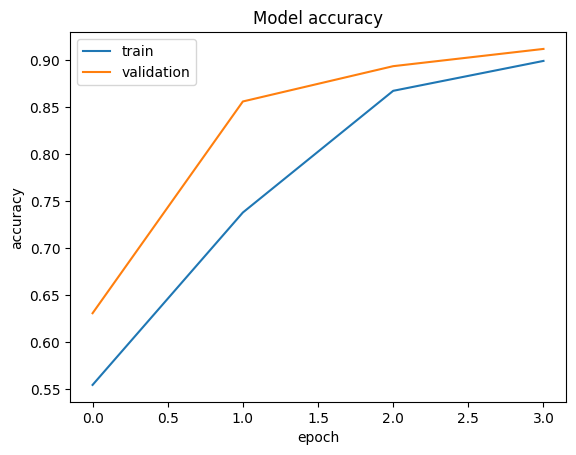

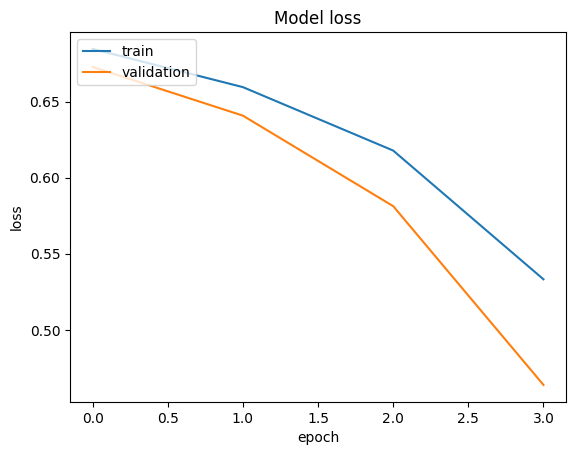

In [39]:
# Define a function to plot the training and validation metrics over epochs
def plot_train_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    # Plot training and validation accuracy
    plt.plot(history['accuracy'])  # Plot training accuracy
    plt.plot(history['val_accuracy'])  # Plot validation accuracy
    plt.title('Model accuracy')  # Set the plot title
    plt.ylabel('accuracy')  # Label the y-axis
    plt.xlabel('epoch')  # Label the x-axis
    plt.legend(['train', 'validation'], loc='upper left')  # Add a legend
    plt.show()  # Display the plot

    # Plot training and validation loss
    plt.plot(history['loss'])  # Plot training loss
    plt.plot(history['val_loss'])  # Plot validation loss
    plt.title('Model loss')  # Set the plot title
    plt.ylabel('loss')  # Label the y-axis
    plt.xlabel('epoch')  # Label the x-axis
    plt.legend(['train', 'validation'], loc='upper left')  # Add a legend
    plt.show()  # Display the plot

# Call the function to visualize training history
plot_train_history(history)

Tests the trained model with a sample text, tokenizes the input, and outputs the predicted label (0 for Not Funny, 1 for Funny)

In [40]:
# Sample Prediction
sample_text = ["Do blind people belive in love at first hear?"]
sample_encoding = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(device)
prediction = model(sample_encoding['input_ids'], attention_mask=sample_encoding['attention_mask'])
print(f"Prediction: {torch.argmax(prediction.logits, dim=1).item()} (0=Not Funny, 1=Funny)")


Prediction: 1 (0=Not Funny, 1=Funny)
